# **Cyclists Outlier Detection**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Read the dataset from a CSV file
cyclists_df = pd.read_csv('../dataset/cyclists_clustering.csv')

cluster_0_drop = ["cyclist_win", "cyclist_experience", "avg_position", "best_position", "birth_year", 
                  "performance_entropy", "min_relative_position", "cyclist_win_ratio", "weighted_podiums",]

cyclists_with_outlier_score = cyclists_df.copy()

cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=cluster_0_drop)
cyclist_numeric_columns = cyclists_df.columns.to_list()

scaler = MinMaxScaler()
cyclists_df = pd.DataFrame(scaler.fit_transform(cyclists_df), columns=cyclists_df.columns)

cyclists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4311 entries, 0 to 4310
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avg_relative_position         4311 non-null   float64
 1   relative_position_std         4311 non-null   float64
 2   avg_performance_vs_startlist  4311 non-null   float64
 3   career_level                  4311 non-null   float64
 4   best_position_std             4311 non-null   float64
dtypes: float64(5)
memory usage: 168.5 KB


## Connectivity approach


In [3]:
from sklearn.neighbors import LocalOutlierFactor

k = 15

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(cyclists_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
cyclists_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

Plot the lof degree to understand where to put a threshold

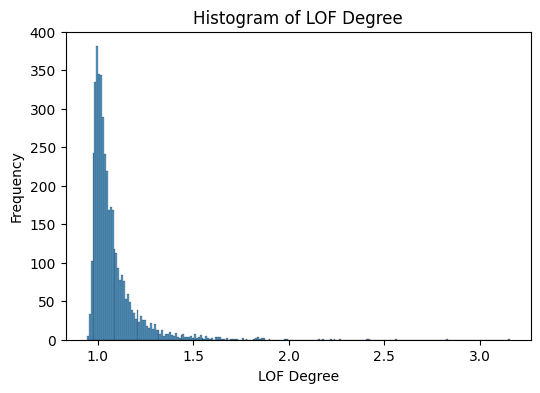

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # Set the figure size
sns.histplot(outlier_degrees, binwidth=0.01)
plt.xlabel('LOF Degree')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Degree')
plt.show()

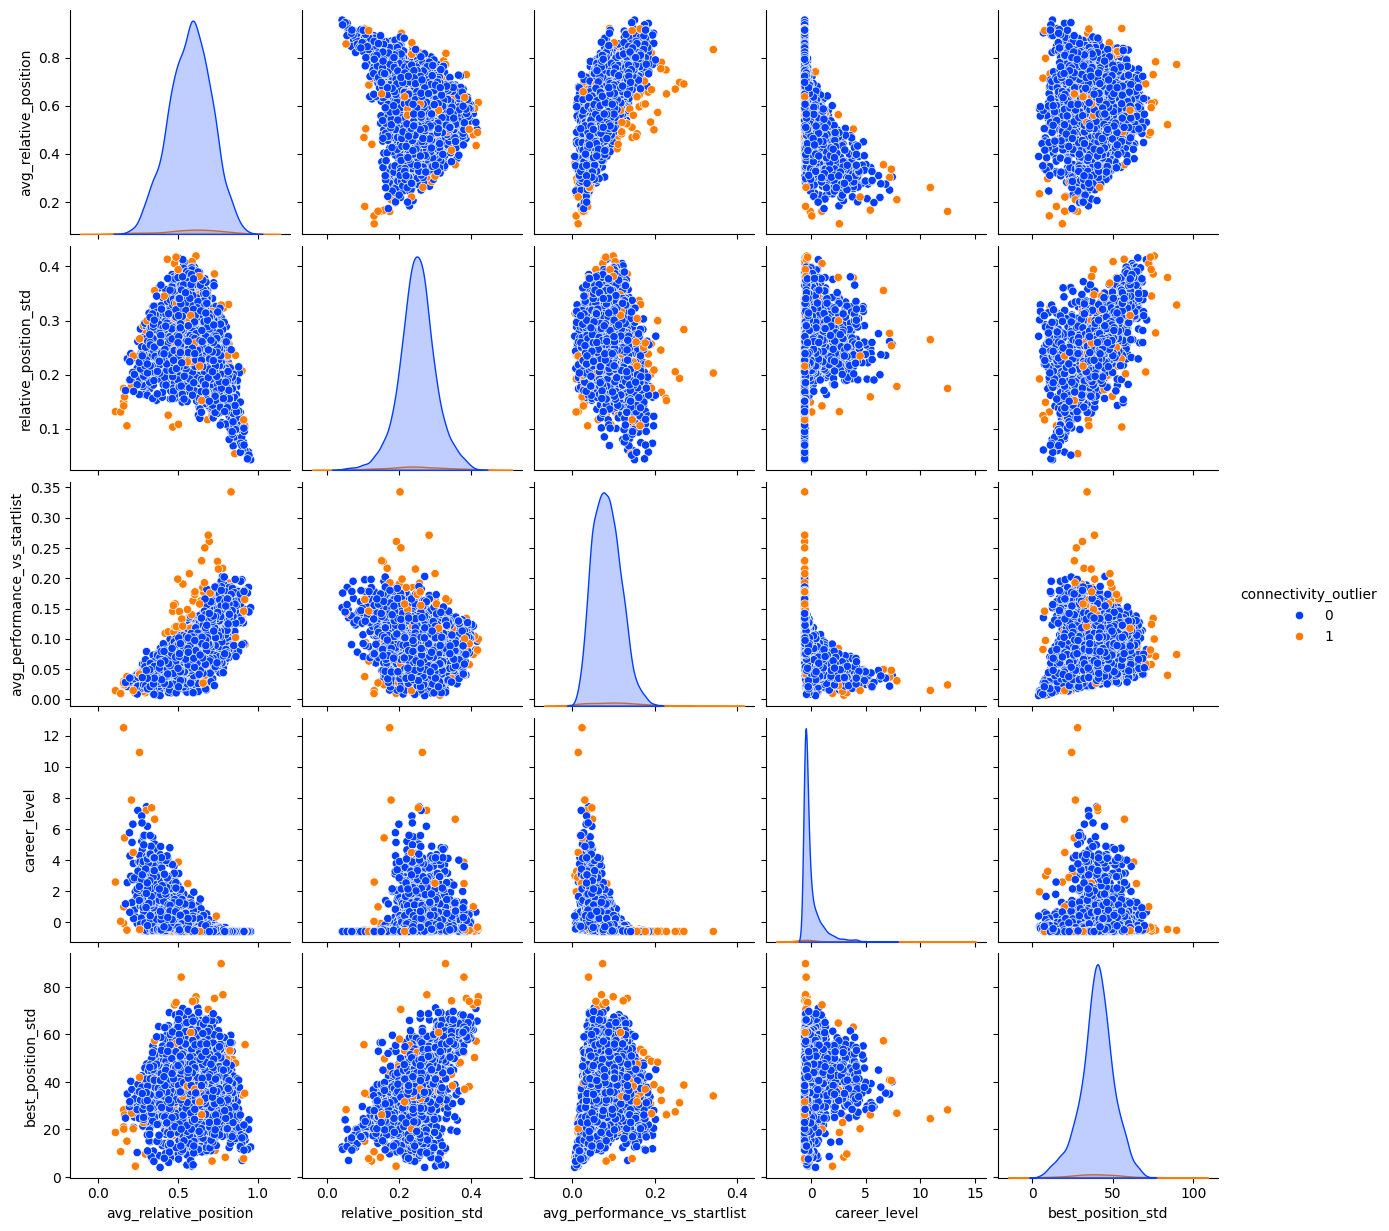

In [5]:

threshold = 1.4 # 1.4 for less outliers

# Threshold and map to {0: inlier, 1: outlier}
cyclists_with_outlier_score['connectivity_outlier'] = (cyclists_with_outlier_score['lof_degree'] > threshold).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ['connectivity_outlier']], hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

Counting outliers identified

In [6]:
cyclists_with_outlier_score["connectivity_outlier"].value_counts()

connectivity_outlier
0    4189
1     122
Name: count, dtype: int64

Analyze some of them

In [7]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['connectivity_outlier'] == 1]
outliers.drop(columns="connectivity_outlier").head()

_url                             name  \
5                 joost-van-leijen                 Joost van Leijen   
40                  corrado-serina                  Corrado  Serina   
63             juan-ayuso-pesquera                      Juan  Ayuso   
68  paulo-jose-dos-santos-ferreira  Paulo José dos Santos  Ferreira   
80                   tadej-pogacar                   Tadej  Pogačar   

    birth_year  nationality  cyclist_experience experience_cat continent  \
5         1984  Netherlands                  29        Amateur    Europe   
40        1975        Italy                  28        Amateur    Europe   
63        2002        Spain                  53        Amateur    Europe   
68        1962     Portugal                  17         Novice    Europe   
80        1998     Slovenia                 166   Intermediate    Europe   

    cyclist_win  cyclist_win_ratio  avg_relative_position  ...  \
5             0           0.000000               0.843161  ...   
40            0           0.000000               0.820926  ...   
63            3           0.056604               0.160543  ...   
68            1           0.058824               0.765199  ...   
80           30           0.180723               0.108822  ...   

    min_relative_position  avg_performance_vs_startlist  performance_entropy  \
5                0.209040                      0.184609             3.319059   
40               0.119205                      0.191841             3.272838   
63               0.006667                      0.029957             3.586042   
68               0.005988                      0.072124             2.703689   
80               0.005650                      0.014569             4.549214   

    weighted_podiums  career_level  top_cyclists avg_position  best_position  \
5           0.000000     -0.574813          Rest   149.137931             36   
40          0.000000     -0.570591          Rest   132.928571             17   
63          7.245283     -0.075287      Top 1300    23.094340              0   
68          5.882353     -0.549363      Top 3500   117.705882              0   
80         30.903614      2.586002       Top 150    15.313253              0   

    best_position_std  lof_degree  
5           49.568657    1.496297  
40          48.706931    1.416339  
63          21.078848    1.451262  
68          48.507428    1.599450  
80          18.713423    1.655777  

[5 rows x 21 columns]

## One-class SVM


In [8]:
from sklearn.svm import OneClassSVM


kernel = "rbf"      # "linear", "poly", "rbf", "sigmoid"
algorithm = OneClassSVM(kernel=kernel, nu=0.025) #0.04 for less outliers
algorithm.fit(cyclists_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(cyclists_df)

outlier_distance_scores = algorithm.score_samples(cyclists_df)

cyclists_with_outlier_score.loc[:, "svm_degree"] = outlier_distance_scores
# map to {0: inliers, : outliers}
cyclists_with_outlier_score.loc[:, "svm_outlier"] = -(outlier_classification_scores  - 1) / 2  

if kernel == "linear":
    support_vectors = cyclists_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

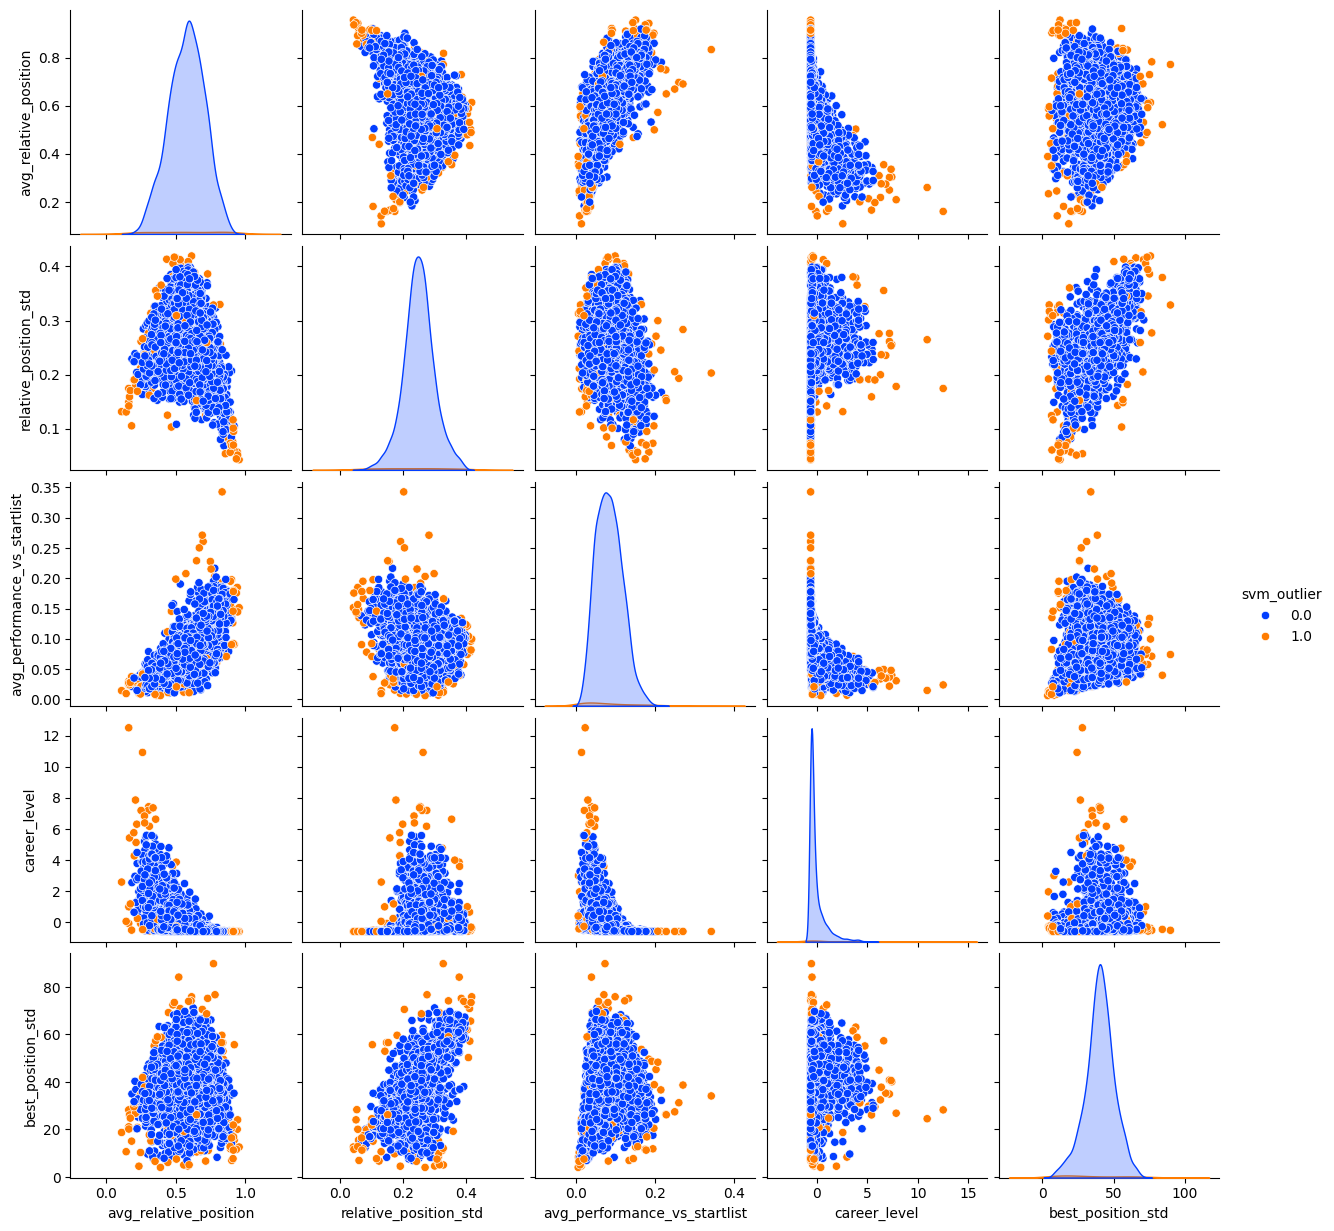

In [9]:
# Classify points as outliers or not

cyclists_with_outlier_score.drop(columns=['svm_degree'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["svm_outlier"]], hue='svm_outlier', diag_kind='kde', palette='bright')
plt.show()

In [10]:
cyclists_with_outlier_score["svm_outlier"].value_counts()

svm_outlier
0.0    4202
1.0     109
Name: count, dtype: int64

Analyze some of them

In [11]:
outliers = cyclists_with_outlier_score[cyclists_with_outlier_score['svm_outlier'] == 1]
outliers.drop(columns=["svm_outlier"]).head()

_url               name  birth_year  nationality  \
5      joost-van-leijen   Joost van Leijen        1984  Netherlands   
40       corrado-serina    Corrado  Serina        1975        Italy   
54        idar-andersen     Idar  Andersen        1999       Norway   
62     michael-matthews  Michael  Matthews        1990    Australia   
63  juan-ayuso-pesquera        Juan  Ayuso        2002        Spain   

    cyclist_experience experience_cat continent  cyclist_win  \
5                   29        Amateur    Europe            0   
40                  28        Amateur    Europe            0   
54                  14         Novice    Europe            0   
62                 485       Advanced   Oceania           25   
63                  53        Amateur    Europe            3   

    cyclist_win_ratio  avg_relative_position  ...  \
5            0.000000               0.843161  ...   
40           0.000000               0.820926  ...   
54           0.000000               0.876299  ...   
62           0.051546               0.344022  ...   
63           0.056604               0.160543  ...   

    avg_performance_vs_startlist  performance_entropy  weighted_podiums  \
5                       0.184609             3.319059          0.000000   
40                      0.191841             3.272838          0.000000   
54                      0.166590             2.635686          0.000000   
62                      0.049099             5.699398         12.678351   
63                      0.029957             3.586042          7.245283   

    career_level  top_cyclists  avg_position best_position  best_position_std  \
5      -0.574813          Rest    149.137931            36          49.568657   
40     -0.570591          Rest    132.928571            17          48.706931   
54     -0.593267          Rest    126.428571            83          16.754858   
62      4.766522        Top 50     55.084536             0          55.137236   
63     -0.075287      Top 1300     23.094340             0          21.078848   

    lof_degree  connectivity_outlier  
5     1.496297                     1  
40    1.416339                     1  
54    1.099147                     0  
62    1.101039                     0  
63    1.451262                     1  

[5 rows x 22 columns]

Analyze which cyclists has both outlier score positive

In [12]:
outliers = cyclists_with_outlier_score[(cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)]
print(f"In total there are {int(len(outliers))} data with both outlier scores positive\n")
outliers.drop(columns=["svm_outlier", "connectivity_outlier"]).head()


In total there are 47 data with both outlier scores positive



_url                    name  birth_year  nationality  \
5         joost-van-leijen        Joost van Leijen        1984  Netherlands   
40          corrado-serina         Corrado  Serina        1975        Italy   
63     juan-ayuso-pesquera             Juan  Ayuso        2002        Spain   
80           tadej-pogacar          Tadej  Pogačar        1998     Slovenia   
148  jean-pierre-berckmans  Jean-Pierre  Berckmans        1948      Belgium   

     cyclist_experience experience_cat continent  cyclist_win  \
5                    29        Amateur    Europe            0   
40                   28        Amateur    Europe            0   
63                   53        Amateur    Europe            3   
80                  166   Intermediate    Europe           30   
148                  10         Novice    Europe            0   

     cyclist_win_ratio  avg_relative_position  ...  min_relative_position  \
5             0.000000               0.843161  ...               0.209040   
40            0.000000               0.820926  ...               0.119205   
63            0.056604               0.160543  ...               0.006667   
80            0.180723               0.108822  ...               0.005650   
148           0.000000               0.733641  ...               0.134146   

     avg_performance_vs_startlist  performance_entropy  weighted_podiums  \
5                        0.184609             3.319059          0.000000   
40                       0.191841             3.272838          0.000000   
63                       0.029957             3.586042          7.245283   
80                       0.014569             4.549214         30.903614   
148                      0.049101             2.191441          0.000000   

     career_level  top_cyclists avg_position  best_position  \
5       -0.574813          Rest   149.137931             36   
40      -0.570591          Rest   132.928571             17   
63      -0.075287      Top 1300    23.094340              0   
80       2.586002       Top 150    15.313253              0   
148     -0.356862      Top 2000    29.900000             10   

     best_position_std  lof_degree  
5            49.568657    1.496297  
40           48.706931    1.416339  
63           21.078848    1.451262  
80           18.713423    1.655777  
148          11.140018    1.634959  

[5 rows x 21 columns]

## Isolation forest


In [13]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(n_estimators=200, contamination=0.020, n_jobs=-1, random_state=42)
isolation_forest.fit(cyclists_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(cyclists_df)       # negative values are outliers
outlier_predictions = isolation_forest.predict(cyclists_df)

# Add the outlier scores to the dataframe
cyclists_with_outlier_score['isolation_forest_score'] = outlier_scores
cyclists_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(cyclists_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    4224
1      87
Name: count, dtype: int64


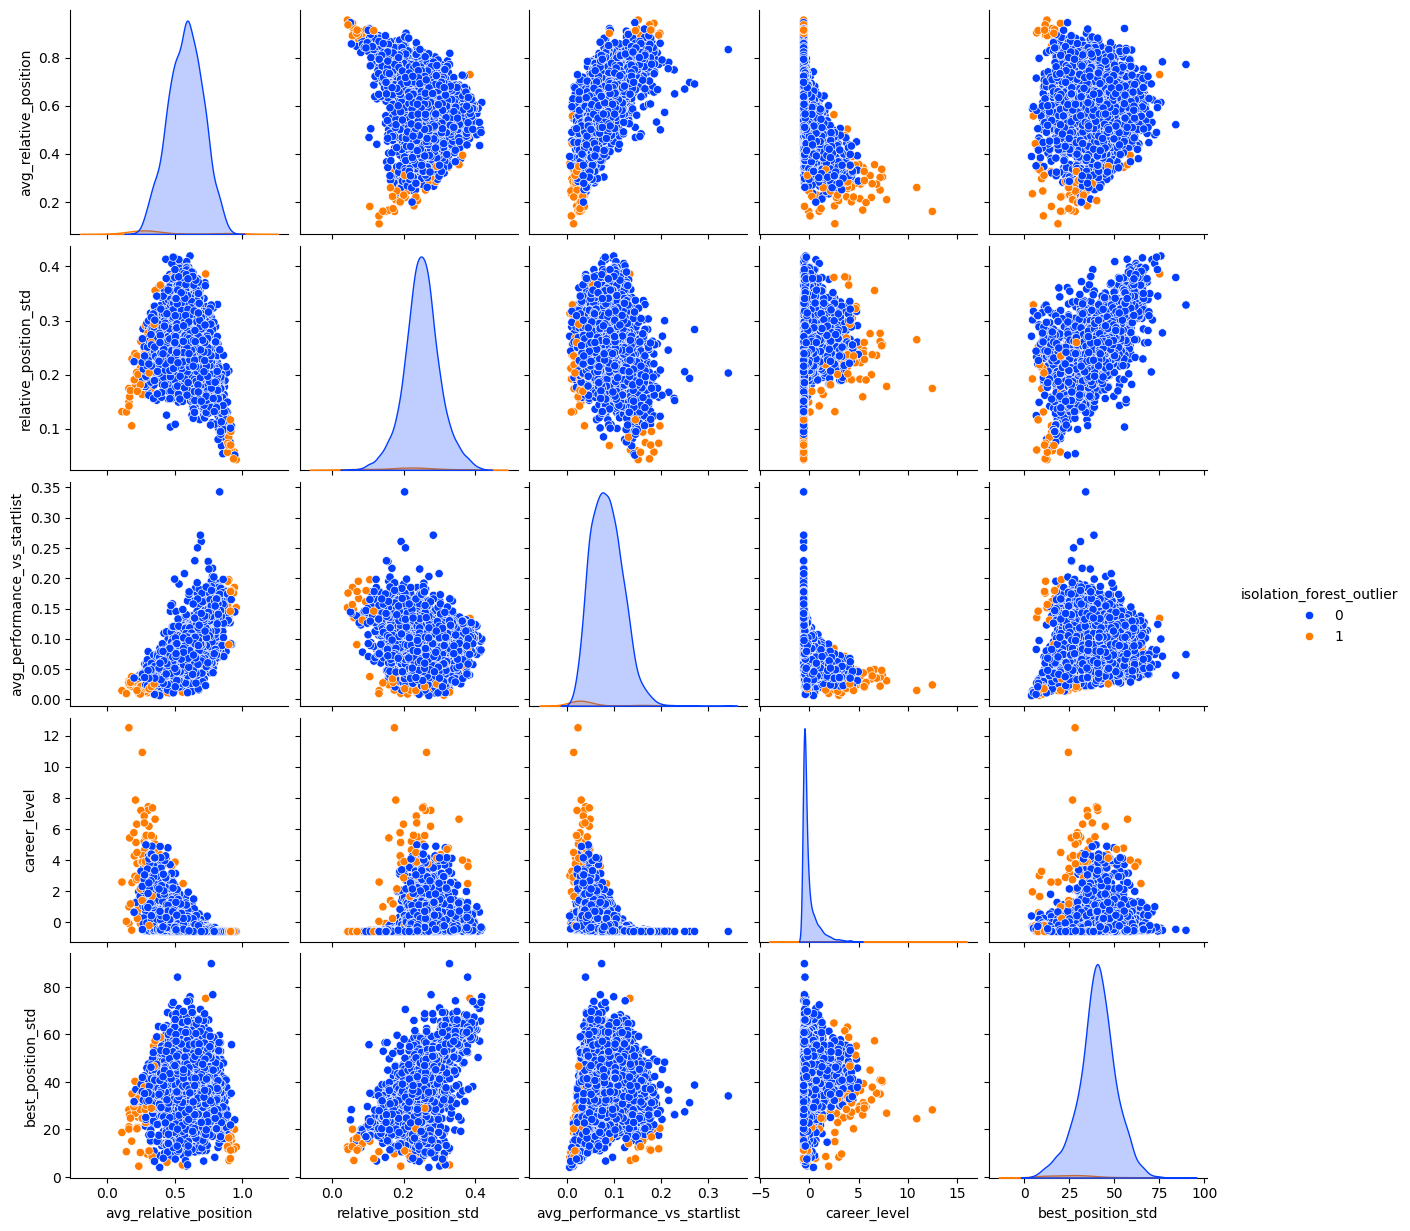

In [14]:
cyclists_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["isolation_forest_outlier"]], hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()

## ENSAMBLING DECISION

Check when at least two outlier score are positive to classify a point as an outlier

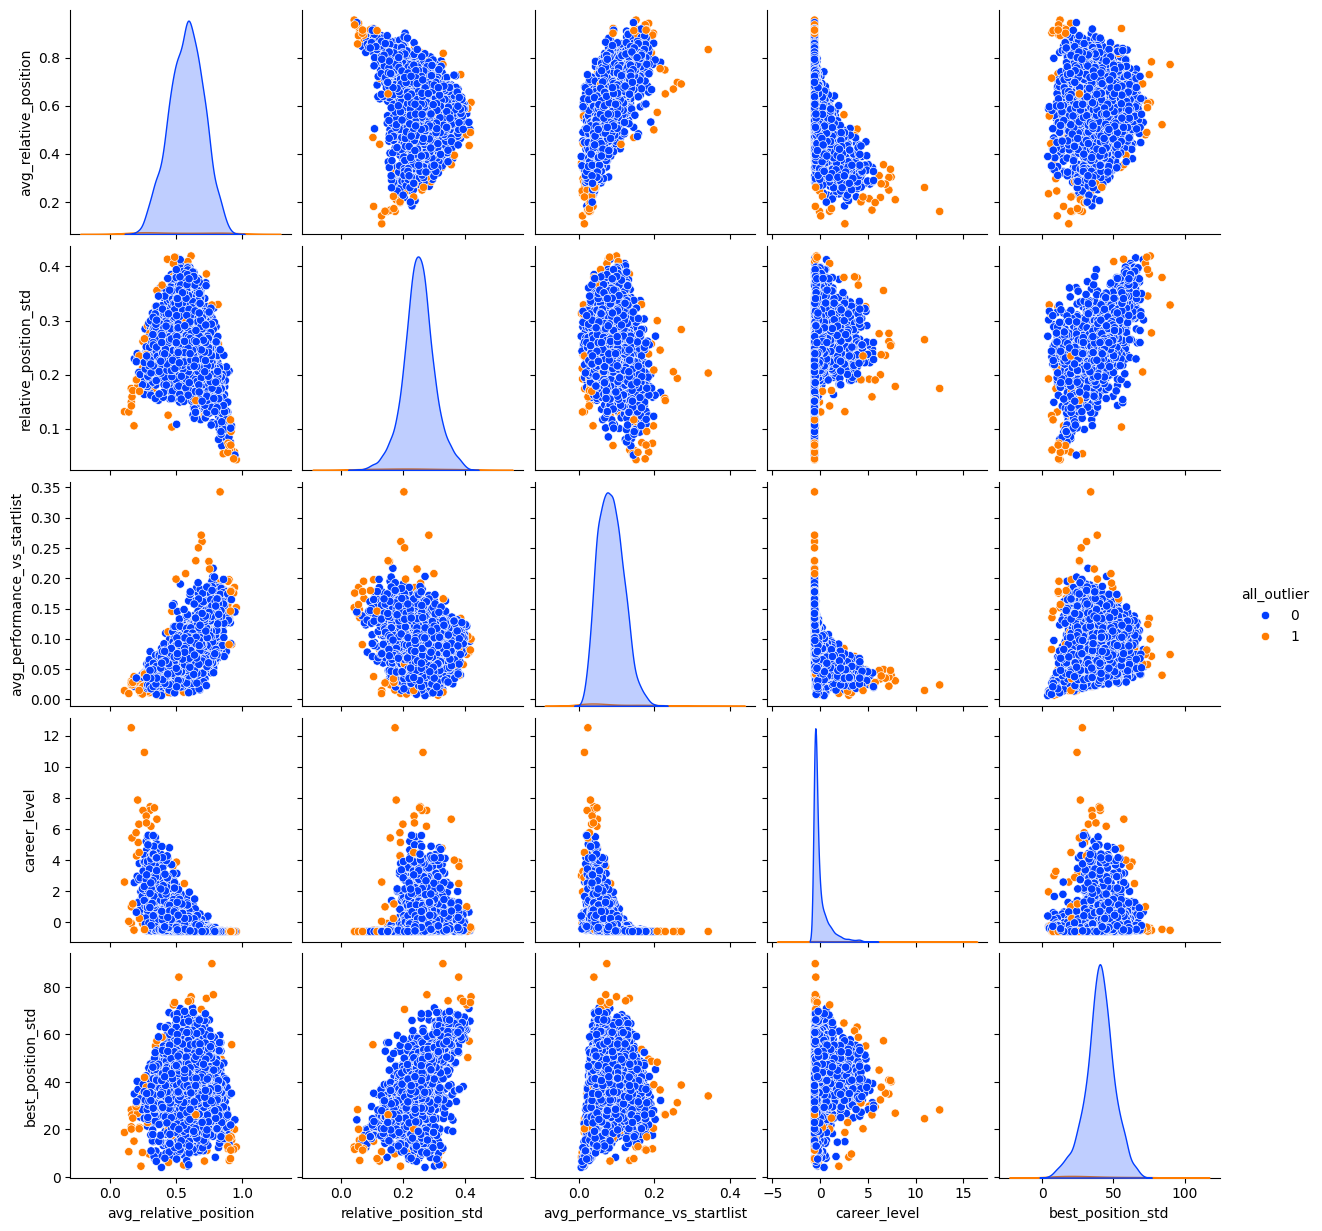

In [15]:
cond1 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['svm_outlier'] == 1) 
cond2 = (cyclists_with_outlier_score['isolation_forest_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond3 = (cyclists_with_outlier_score['svm_outlier'] == 1) & (cyclists_with_outlier_score['connectivity_outlier'] == 1)
cond = cond1 | cond2 | cond3

cyclists_with_outlier_score['all_outlier'] = (cond).astype(int)

sns.pairplot(cyclists_with_outlier_score[cyclist_numeric_columns + ["all_outlier"]], hue='all_outlier', diag_kind='kde', palette='bright')
plt.show()

Count how many outliers individued by ensambling methods

In [16]:
print(cyclists_with_outlier_score['all_outlier'].value_counts())

all_outlier
0    4229
1      82
Name: count, dtype: int64


Trying to characterize the outlier

In [ ]:
outlier_df = cyclists_with_outlier_score[cyclist_numeric_columns + ['all_outlier']]
outlier_df = outlier_df[outlier_df['all_outlier'] == 1]

# Normalize the data
normalized_outlier_df = pd.DataFrame(scaler.transform(outlier_df[cyclist_numeric_columns]), columns=cyclist_numeric_columns)

print(normalized_outlier_df.describe())

NameError: name 'cyclists_with_outlier_score' is not defined

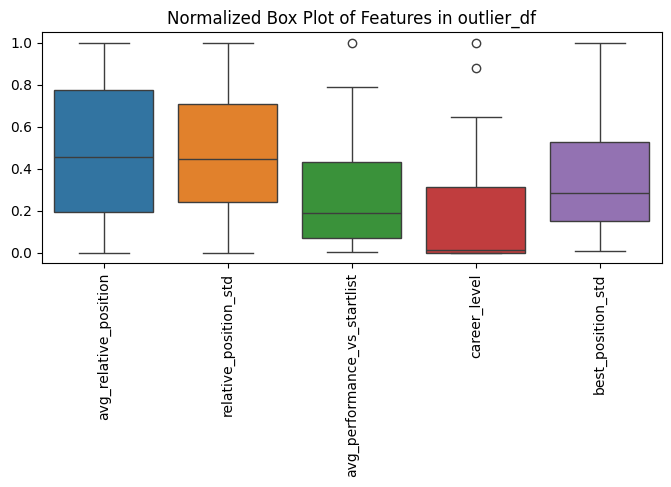

In [18]:
 # Create a box plot
plt.figure(figsize=(8, 3))
sns.boxplot(data=normalized_outlier_df[cyclist_numeric_columns])
plt.xticks(rotation=90)
plt.title('Normalized Box Plot of Features in outlier_df')
plt.show()

In [19]:
cyclists_with_outlier_score = cyclists_with_outlier_score[cyclists_with_outlier_score['all_outlier'] != 1]
cyclists_with_outlier_score.drop(columns=['connectivity_outlier', 'svm_outlier', 'isolation_forest_outlier' ,'all_outlier', 'lof_degree'], inplace=True)

In [20]:
cyclists_with_outlier_score.value_counts("top_cyclists")

top_cyclists
Rest        781
Top 3000    496
Top 3500    496
Top 2500    495
Top 1700    399
Top 500     345
Top 2000    297
Top 1300    296
Top 750     250
Top 1000    249
Top 150      92
Top 50       27
Top 20        5
Name: count, dtype: int64

Rescaling top cyclists after outlier detection

In [21]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = cyclists_with_outlier_score.sort_values(by='career_level', ascending=False)

# Define the bins and labels
"""bins = [0, 21, 51, 151, 501, 1001, 1501, 2001, 2501, 3001, 3501, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 1000', 'Top 1501', 'Top 2000', 'Top 2500', 'Top 3000','Top 3500', 'Rest']
"""

bins = [0, 21, 51, 151, 501, 751, 1001, 1301, 1701, 2001, 2501, 3001, 3501, len(sorted_cyclists_df)]
labels = ['Top 20', 'Top 50', 'Top 150', 'Top 500', 'Top 750', 'Top 1000', 'Top 1300', 'Top 1700', 'Top 2000', 'Top 2500', 'Top 3000','Top 3500', 'Rest']

# Create a new column 'career_level_category' based on the bins
sorted_cyclists_df['top_cyclists'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

cyclists_with_outlier_score.drop(columns=['top_cyclists'], inplace=True)
# Add the 'top_cyclists' column to the original cyclists_df
cyclists_with_outlier_score = cyclists_with_outlier_score.merge(sorted_cyclists_df[['_url', 'top_cyclists']], on='_url', how='left')


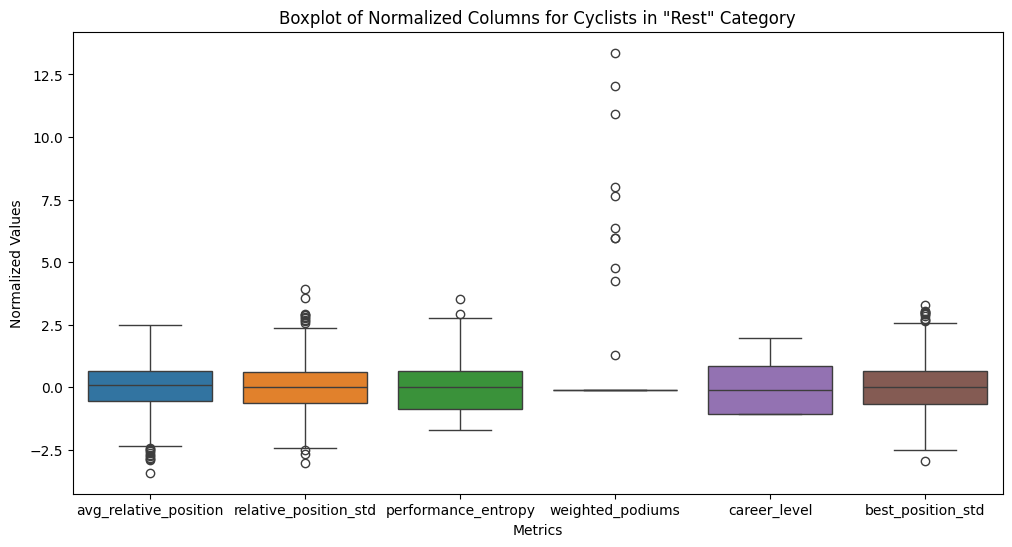

In [22]:
from sklearn.preprocessing import StandardScaler

# Filter the dataframe for rows where top_cyclists is 'Rest'
rest_cyclists_df = cyclists_with_outlier_score[cyclists_with_outlier_score['top_cyclists'] == 'Rest']

# Select the columns to be normalized
columns_to_normalize = ['avg_relative_position', 'relative_position_std', 'performance_entropy', 'weighted_podiums', 'career_level', 'best_position_std']

# Normalize the selected columns

scaler = StandardScaler()
normalized_data = scaler.fit_transform(rest_cyclists_df[columns_to_normalize])

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize)

# Plot the boxplot for the normalized columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=normalized_df)
plt.title('Boxplot of Normalized Columns for Cyclists in "Rest" Category')
plt.xlabel('Metrics')
plt.ylabel('Normalized Values')
plt.show()

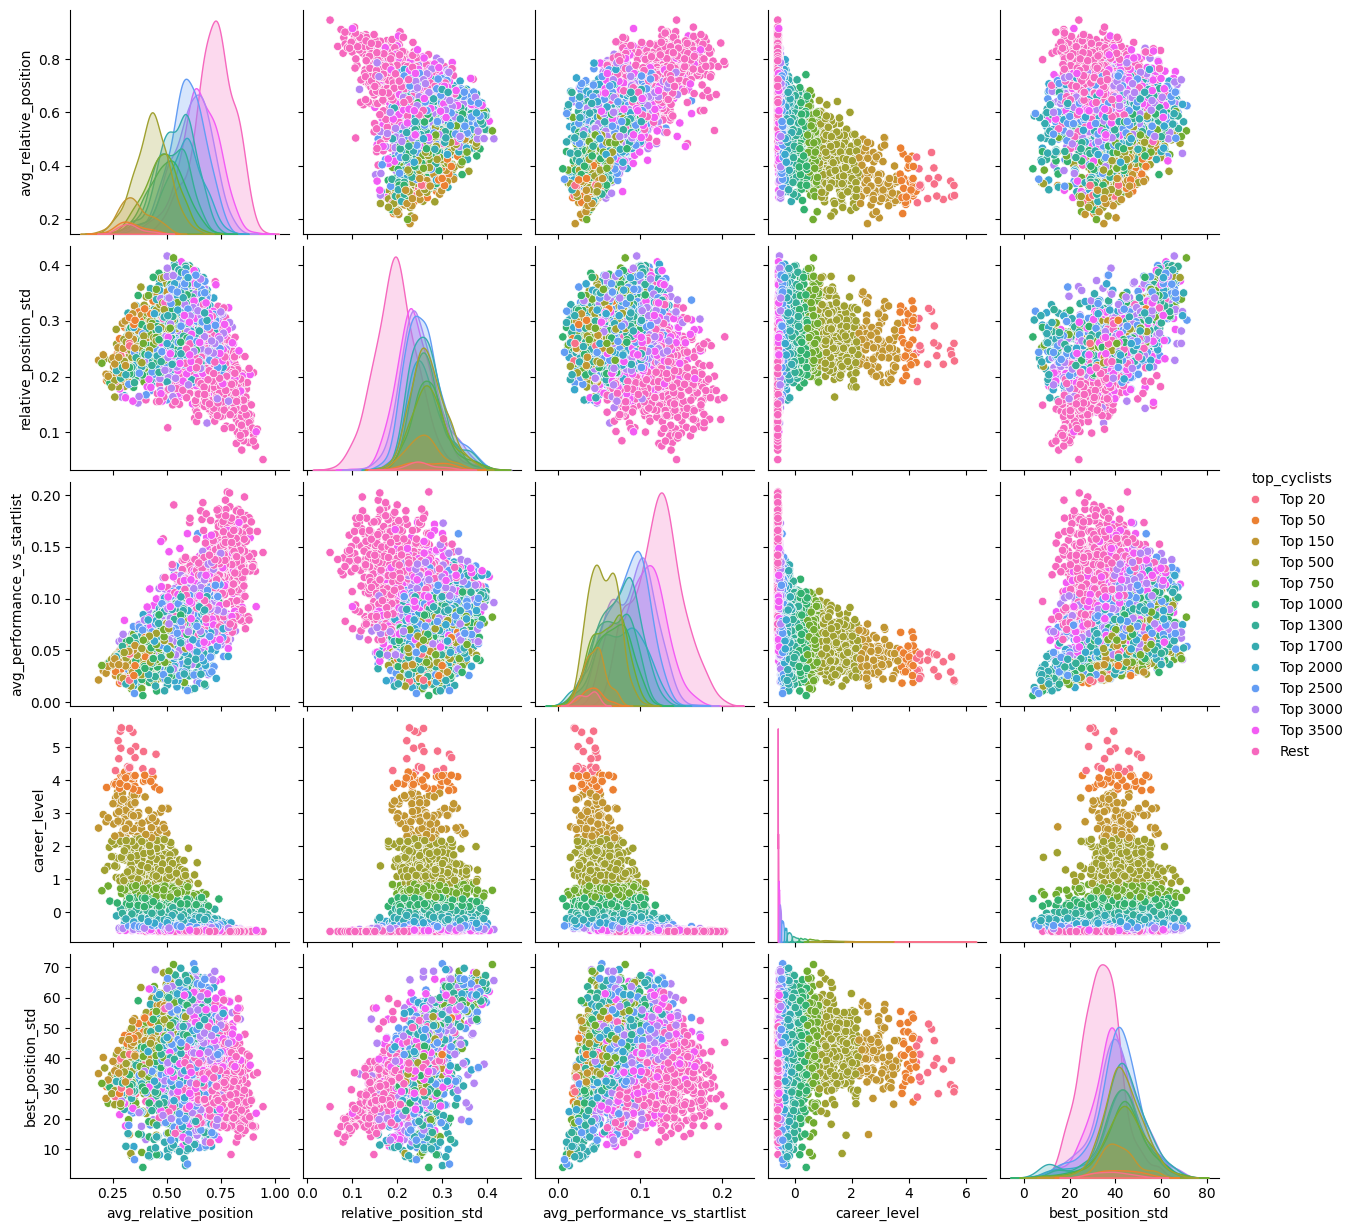

In [23]:
sns.pairplot(cyclists_with_outlier_score.drop(columns=cluster_0_drop), hue='top_cyclists')
plt.show()

In [24]:
cyclists_with_outlier_score.columns

Index(['_url', 'name', 'birth_year', 'nationality', 'cyclist_experience',
       'experience_cat', 'continent', 'cyclist_win', 'cyclist_win_ratio',
       'avg_relative_position', 'relative_position_std',
       'min_relative_position', 'avg_performance_vs_startlist',
       'performance_entropy', 'weighted_podiums', 'career_level',
       'avg_position', 'best_position', 'best_position_std', 'top_cyclists'],
      dtype='object')

In [25]:
cyclists_with_outlier_score.to_csv('../dataset/cyclists_outlier.csv', index=False)

---

# **Races Outlier Detection**

In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

races_df = pd.read_csv('../dataset/races_clustering.csv')

races_complexity_cluster_col = ["climb_total", "difficulty_index_2", "duration_to_length"]

races_with_outlier_score = races_df.copy()

races_df = races_df.select_dtypes(include=[np.number])
races_df.drop(columns=['profile'], inplace=True)
races_numeric_columns = races_df[races_complexity_cluster_col].columns.to_list()

scaler = MinMaxScaler()
races_df = pd.DataFrame(scaler.fit_transform(races_df), columns=races_df.columns)

races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2614 entries, 0 to 2613
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   points              2614 non-null   float64
 1   length              2614 non-null   float64
 2   climb_total         2614 non-null   float64
 3   startlist_quality   2614 non-null   float64
 4   cyclist_number      2614 non-null   float64
 5   avg_cyclists_level  2614 non-null   float64
 6   average_age         2614 non-null   float64
 7   race_importance     2614 non-null   float64
 8   difficulty_idx      2614 non-null   float64
 9   avg_slope           2614 non-null   float64
 10  min_duration        2614 non-null   float64
 11  duration_to_length  2614 non-null   float64
 12  startlist_entropy   2614 non-null   float64
 13  points_entropy      2614 non-null   float64
 14  difficulty_index_2  2614 non-null   float64
dtypes: float64(15)
memory usage: 306.5 KB


## Connectivity approach


In [99]:
from sklearn.neighbors import LocalOutlierFactor

k = 15

algorithm = LocalOutlierFactor(n_neighbors=k)
algorithm.fit(races_df)

# negated outlier scores: the higher, the more of an outlier
outlier_degrees = - algorithm.negative_outlier_factor_
races_with_outlier_score.loc[:, "lof_degree"] = outlier_degrees

Plot the lof degree to understand where to put a threshold

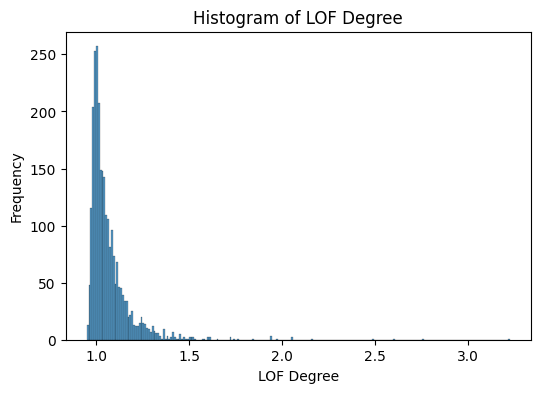

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # Set the figure size
sns.histplot(outlier_degrees, binwidth=0.01)
plt.xlabel('LOF Degree')
plt.ylabel('Frequency')
plt.title('Histogram of LOF Degree')
plt.show()

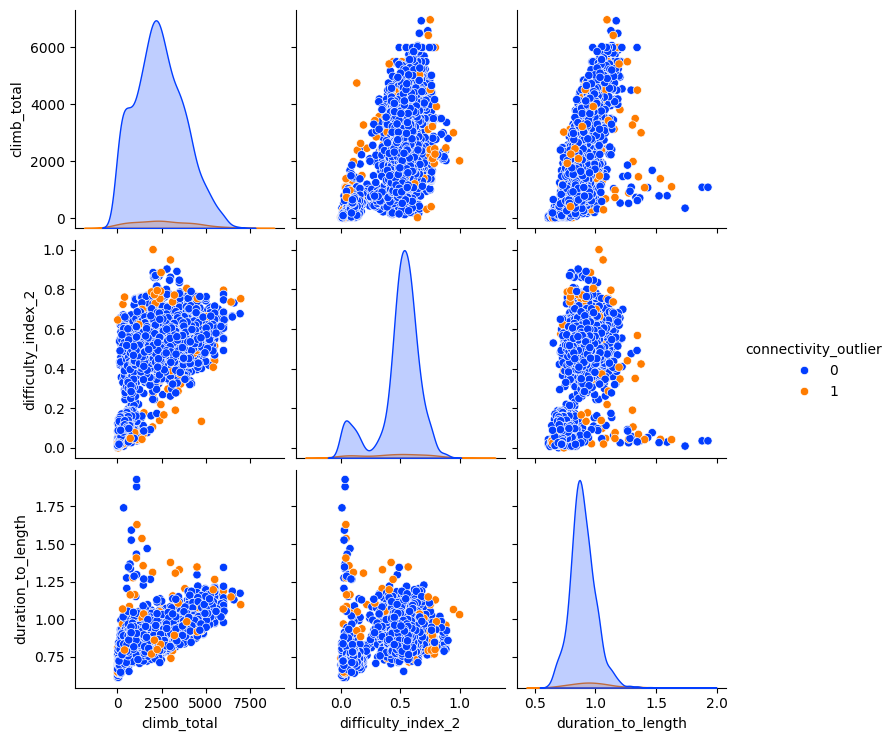

In [101]:

threshold = 1.28 # 1.4 for less outliers

# Threshold and map to {0: inlier, 1: outlier}
races_with_outlier_score['connectivity_outlier'] = (races_with_outlier_score['lof_degree'] > threshold).astype(int)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ['connectivity_outlier']], hue='connectivity_outlier', diag_kind='kde', palette='bright')
plt.show()

Counting outliers identified

In [102]:
races_with_outlier_score["connectivity_outlier"].value_counts()

connectivity_outlier
0    2498
1     116
Name: count, dtype: int64

Analyze some of them

In [103]:
outliers = races_with_outlier_score[races_with_outlier_score['connectivity_outlier'] == 1]
outliers.drop(columns="connectivity_outlier").head()

_url  \
13              dauphine/2013/stage-1   
68              dauphine/2020/stage-2   
70              dauphine/2020/stage-4   
71              dauphine/2020/stage-5   
96  dwars-door-vlaanderen/2016/result   

                                            name  points    length  \
13                         Critérium du Dauphiné    50.0  121000.0   
68                         Critérium du Dauphiné    50.0  135000.0   
70                         Critérium du Dauphiné    50.0  148500.0   
71                         Critérium du Dauphiné    50.0  142500.0   
96  Dwars door Vlaanderen / A travers la Flandre   125.0  199700.0   

    climb_total  profile  startlist_quality  is_tarmac  start_date  duration  \
13       2582.0      2.0                985       True  2013-06-02  03:17:35   
68       2878.0      5.0               1243       True  2020-08-13  03:39:40   
70       4669.0      5.0               1243       True  2020-08-15  04:27:56   
71       4391.0      5.0               1243       True  2020-08-16  03:58:39   
96       1318.0      2.0                460      False  2016-03-23  04:48:27   

    ...  top_complex_races  season  avg_slope  min_duration  \
13  ...           Top 2400  Spring     2.1339         11855   
68  ...           Top 2400  Summer     2.1319         13180   
70  ...           Top 2000  Summer     3.1441         16076   
71  ...           Top 2400  Summer     3.0814         14319   
96  ...           Top 1000  Spring     0.6600         17307   

   duration_to_length              real_name startlist_entropy points_entropy  \
13             0.9798               dauphine          3.528066      -0.000000   
68             0.9763               dauphine          3.528066      -0.000000   
70             1.0826               dauphine          3.528066      -0.000000   
71             1.0048               dauphine          3.528066      -0.000000   
96             0.8666  dwars-door-vlaanderen          2.807355       0.591673   

    difficulty_index_2  lof_degree  
13            0.356148    1.295215  
68            0.397698    1.350525  
70            0.437817    1.301734  
71            0.420005    1.400009  
96            0.589618    1.519471  

[5 rows x 26 columns]

## One-class SVM


In [104]:
from sklearn.svm import OneClassSVM


kernel = "rbf"      # "linear", "poly", "rbf", "sigmoid"
algorithm = OneClassSVM(kernel=kernel, nu=0.05) #0.04 for less outliers
algorithm.fit(races_df)

# this implementation provides two different scores:
#   outlier classification in {+1, -1}
#   outlier scores in R: distance from hyperplane
outlier_classification_scores = algorithm.predict(races_df)

outlier_distance_scores = algorithm.score_samples(races_df)

races_with_outlier_score.loc[:, "svm_degree"] = outlier_distance_scores
# map to {0: inliers, : outliers}
races_with_outlier_score.loc[:, "svm_outlier"] = -(outlier_classification_scores  - 1) / 2  

print(races_with_outlier_score['svm_outlier'].value_counts())

if kernel == "linear":
    support_vectors = races_df.iloc[algorithm.support_]
    
else:
    support_vectors = None

svm_outlier
0.0    2483
1.0     131
Name: count, dtype: int64


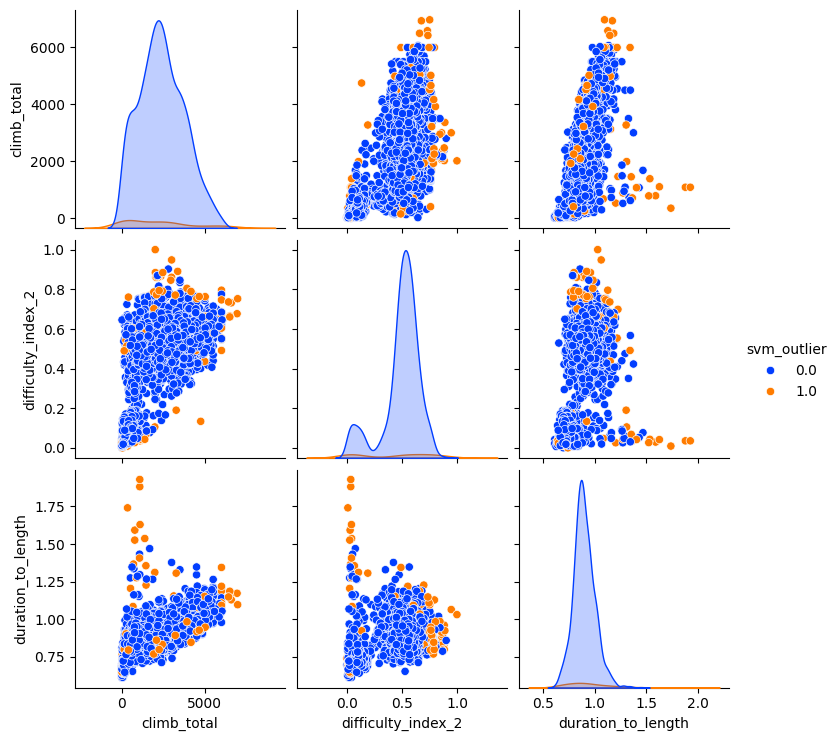

In [105]:
# Classify points as outliers or not

races_with_outlier_score.drop(columns=['svm_degree'], inplace=True)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ["svm_outlier"]], hue='svm_outlier', diag_kind='kde', palette='bright')
plt.show()

In [106]:
races_with_outlier_score["svm_outlier"].value_counts()

svm_outlier
0.0    2483
1.0     131
Name: count, dtype: int64

Analyze some of them

In [107]:
outliers = races_with_outlier_score[races_with_outlier_score['svm_outlier'] == 1]
outliers.drop(columns=["svm_outlier"]).head()

_url                   name  points    length  \
36        dauphine/2016/prologue  Criterium du Dauphiné    50.0    4000.0   
142  giro-d-italia/2001/stage-14          Giro d'Italia    80.0  163000.0   
287  giro-d-italia/2008/stage-16          Giro d'Italia    80.0   12900.0   
328  giro-d-italia/2010/stage-16          Giro d'Italia    80.0   12900.0   
346  giro-d-italia/2011/stage-15          Giro d'Italia    80.0  229000.0   

     climb_total  profile  startlist_quality  is_tarmac  start_date  duration  \
36         348.0      5.0               1182       True  2016-06-05  00:11:36   
142       3128.0      4.0                920       True  2001-06-02  05:13:30   
287       1084.0      5.0               1058       True  2008-05-26  00:40:26   
328       1084.0      5.0                878       True  2010-05-25  00:41:28   
346       6939.0      5.0                891       True  2011-05-22  07:27:14   

     ...  season  avg_slope  min_duration  duration_to_length      real_name  \
36   ...  Spring     8.7000           696              1.7400       dauphine   
142  ...  Spring     1.9190         18810              1.1540  giro-d-italia   
287  ...  Spring     8.4031          2426              1.8806  giro-d-italia   
328  ...  Spring     8.4031          2488              1.9287  giro-d-italia   
346  ...  Spring     3.0301         26834              1.1718  giro-d-italia   

     startlist_entropy points_entropy difficulty_index_2  lof_degree  \
36            3.528066      -0.000000           0.008912    1.229761   
142           4.498913       0.128518           0.480787    2.487591   
287           4.498913       0.128518           0.035346    1.178199   
328           4.498913       0.128518           0.035346    1.243959   
346           4.498913       0.128518           0.676753    1.238842   

     connectivity_outlier  
36                      0  
142                     1  
287                     0  
328                     0  
346                     0  

[5 rows x 27 columns]

Analyze which cyclists has both outlier score positive

In [108]:
outliers = races_with_outlier_score[(races_with_outlier_score['svm_outlier'] == 1) & (races_with_outlier_score['connectivity_outlier'] == 1)]
print(f"In total there are {int(len(outliers))} data with both outlier scores positive\n")
outliers.drop(columns=["svm_outlier", "connectivity_outlier"]).head()


In total there are 40 data with both outlier scores positive



_url           name  points    length  \
142  giro-d-italia/2001/stage-14  Giro d'Italia    80.0  163000.0   
617     gran-camino/2022/stage-1    Gran Camiño    20.0  165000.0   
618     gran-camino/2022/stage-2    Gran Camiño    20.0  177600.0   
619     gran-camino/2022/stage-3    Gran Camiño    20.0  148400.0   
620     gran-camino/2022/stage-4    Gran Camiño    20.0   15800.0   

     climb_total  profile  startlist_quality  is_tarmac  start_date  duration  \
142       3128.0      4.0                920       True  2001-06-02  05:13:30   
617       1993.0      2.0                225       True  2022-02-24  03:56:59   
618       3006.0      3.0                225       True  2022-02-25  04:35:52   
619       2669.0      2.0                225       True  2022-02-26  03:42:42   
620        208.0      1.0                225       True  2022-02-27  00:20:19   

     ...  top_complex_races  season  avg_slope  min_duration  \
142  ...           Top 1700  Spring     1.9190         18810   
617  ...           Top 2000  Winter     1.2079         14219   
618  ...           Top 1300  Winter     1.6926         16552   
619  ...           Top 2400  Winter     1.7985         13362   
620  ...               Rest  Winter     1.3165          1219   

    duration_to_length      real_name startlist_entropy points_entropy  \
142             1.1540  giro-d-italia          4.498913       0.128518   
617             0.8618    gran-camino          0.985228      -0.000000   
618             0.9320    gran-camino          0.985228      -0.000000   
619             0.9004    gran-camino          0.985228      -0.000000   
620             0.7715    gran-camino          0.985228      -0.000000   

     difficulty_index_2  lof_degree  
142            0.480787    2.487591  
617            0.486682    1.528042  
618            0.524103    1.758626  
619            0.437451    1.719974  
620            0.043920    2.761075  

[5 rows x 26 columns]

## Isolation forest


In [109]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest algorithm with a lower contamination value
isolation_forest = IsolationForest(n_estimators=200, contamination=0.04, n_jobs=-1, random_state=42)
isolation_forest.fit(races_df)

# Compute the outlier scores
outlier_scores = isolation_forest.decision_function(races_df)       # negative values are outliers
outlier_predictions = isolation_forest.predict(races_df)

# Add the outlier scores to the dataframe
races_with_outlier_score['isolation_forest_score'] = outlier_scores
races_with_outlier_score['isolation_forest_outlier'] = (outlier_predictions == -1).astype(int)

print(races_with_outlier_score['isolation_forest_outlier'].value_counts())

isolation_forest_outlier
0    2509
1     105
Name: count, dtype: int64


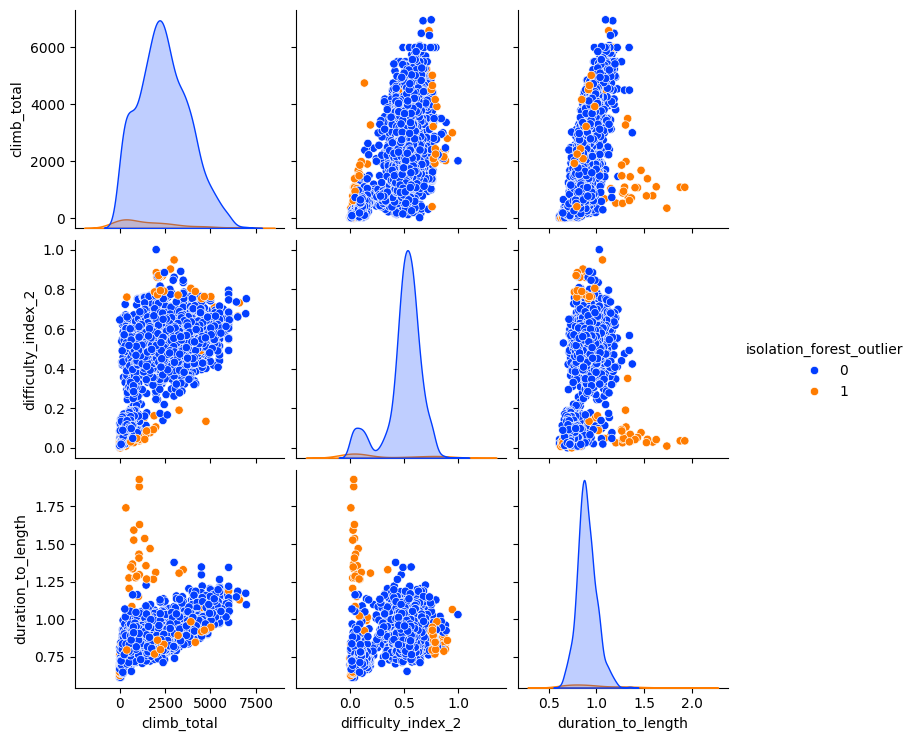

In [110]:
races_with_outlier_score.drop(columns=['isolation_forest_score'], inplace=True)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ["isolation_forest_outlier"]], hue="isolation_forest_outlier", diag_kind='kde', palette='bright')
plt.show()

## ENSAMBLING DECISION

Check when at least two outlier score are positive to classify a point as an outlier

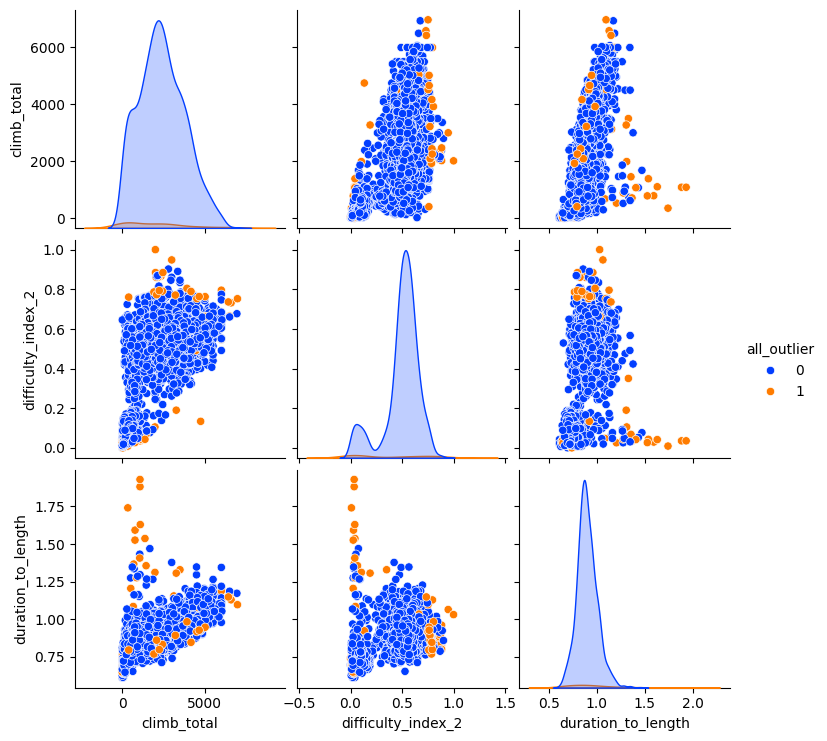

In [111]:
cond1 = (races_with_outlier_score['isolation_forest_outlier'] == 1) & (races_with_outlier_score['svm_outlier'] == 1) 
cond2 = (races_with_outlier_score['isolation_forest_outlier'] == 1) & (races_with_outlier_score['connectivity_outlier'] == 1)
cond3 = (races_with_outlier_score['svm_outlier'] == 1) & (races_with_outlier_score['connectivity_outlier'] == 1)
cond = cond1 | cond2 | cond3

races_with_outlier_score['all_outlier'] = (cond).astype(int)

sns.pairplot(races_with_outlier_score[races_numeric_columns + ["all_outlier"]], hue='all_outlier', diag_kind='kde', palette='bright')
plt.show()

Count how many outliers individued by both methods

In [112]:
print(races_with_outlier_score['all_outlier'].value_counts())

all_outlier
0    2525
1      89
Name: count, dtype: int64


Trying to characterize the outlier

In [113]:
outlier_df.columns

Index(['climb_total', 'difficulty_index_2', 'duration_to_length',
       'all_outlier'],
      dtype='object')

In [114]:
outlier_df = races_with_outlier_score[races_numeric_columns + ['all_outlier']]
outlier_df = outlier_df[outlier_df['all_outlier'] == 1]

scaler = MinMaxScaler()

# Normalize the data
normalized_outlier_df = pd.DataFrame(scaler.fit_transform(outlier_df[races_numeric_columns]), columns=races_numeric_columns)

normalized_outlier_df.describe()

climb_total  difficulty_index_2  duration_to_length
count    89.000000           89.000000           89.000000
mean      0.286604            0.377910            0.254251
std       0.269258            0.350366            0.223668
min       0.000000            0.000000            0.000000
25%       0.026104            0.035346            0.097075
50%       0.284854            0.363258            0.200140
75%       0.430006            0.760494            0.343030
max       1.000000            1.000000            1.000000

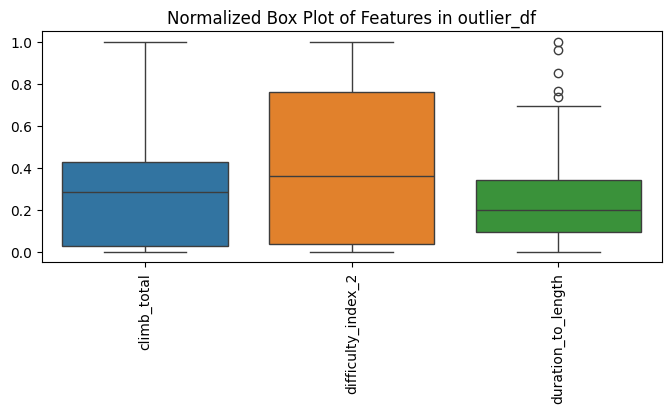

In [115]:
 # Create a box plot
plt.figure(figsize=(8, 3))
sns.boxplot(data=normalized_outlier_df[races_numeric_columns])
plt.xticks(rotation=90)
plt.title('Normalized Box Plot of Features in outlier_df')
plt.show()

In [116]:
# Create a pairplot to visualize the relationships between features in the normalized outlier dataframe
#sns.pairplot(normalized_outlier_df)
# plt.show()

In [117]:
races_with_outlier_score = races_with_outlier_score[races_with_outlier_score['all_outlier'] != 1]
races_with_outlier_score.drop(columns=['connectivity_outlier', 'svm_outlier', 'isolation_forest_outlier' ,'all_outlier', 'lof_degree'], inplace=True)

In [118]:
races_with_outlier_score.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'is_tarmac', 'start_date', 'duration',
       'cyclist_number', 'avg_cyclists_level', 'average_age',
       'race_importance', 'top_races', 'difficulty_idx', 'top_complex_races',
       'season', 'avg_slope', 'min_duration', 'duration_to_length',
       'real_name', 'startlist_entropy', 'points_entropy',
       'difficulty_index_2'],
      dtype='object')

In [119]:
races_with_outlier_score.to_csv('../dataset/races_outlier.csv', index=False)